In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [10]:
import tensorflow_datasets as tfds

In [15]:
# datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
(train_data, test_data), info = tfds.load(
    # Use the version pre-encoded with an ~8k vocabulary.
    'imdb_reviews/subwords8k', 
    # Return the train/test datasets as a tuple.
    split = (tfds.Split.TRAIN,tfds.Split.TEST),
    # Return (example, label) pairs from the dataset (instead of a dictionary).
    as_supervised=True,
    # Also return the `info` structure. 
    with_info=True)

Dataset imdb_reviews downloaded and prepared to /Users/zhongqiqiang/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [14]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='/Users/zhongqiqiang/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
        'train': 

In [16]:
encoder = info.features['text'].encoder

In [17]:
print ('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


In [18]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print ('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print ('The original string: "{}"'.format(original_string))

assert original_string == sample_string

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [19]:
for train_example, train_label in train_data.take(1):
  print('Encoded text:', train_example[:10].numpy())
  print('Label:', train_label.numpy())

Encoded text: [  62   18   41  604  927   65    3  644 7968   21]
Label: 0


In [20]:
encoder.decode(train_example)

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

In [25]:
BUFFER_SIZE = 1000

In [26]:
train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32))

test_batches = (
    test_data
    .padded_batch(32))

In [27]:
for example_batch, label_batch in train_batches.take(2):
  print("Batch shape:", example_batch.shape)
  print("label shape:", label_batch.shape)

Batch shape: (32, 1296)
label shape: (32,)
Batch shape: (32, 958)
label shape: (32,)


In [46]:
embed_size = 16
model = keras.models.Sequential([
    keras.layers.Embedding(encoder.vocab_size, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.SimpleRNN(64, return_sequences=True),
#     keras.layers.Dropout(0.5),          
    keras.layers.SimpleRNN(64),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_batches,
                    epochs=4,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/4
782/782 [==============================] - 508s 646ms/step - loss: 0.6787 - accuracy: 0.5542 - val_loss: 0.6062 - val_accuracy: 0.6604
Epoch 2/4
782/782 [==============================] - 506s 647ms/step - loss: 0.6290 - accuracy: 0.6372 - val_loss: 0.6289 - val_accuracy: 0.6198
Epoch 3/4
782/782 [==============================] - 508s 650ms/step - loss: 0.5719 - accuracy: 0.6968 - val_loss: 0.6461 - val_accuracy: 0.6542
Epoch 4/4
782/782 [==============================] - 507s 649ms/step - loss: 0.4964 - accuracy: 0.7581 - val_loss: 0.6413 - val_accuracy: 0.6823


In [47]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 99s 126ms/step - loss: 0.7193 - accuracy: 0.6407
Loss:  0.7192507982254028
Accuracy:  0.6406800150871277


In [49]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(encoder.vocab_size, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.LSTM(128, return_sequences=True),
#     keras.layers.Dropout(0.5),          
    keras.layers.LSTM(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_batches,
                    epochs=5,
                    validation_data=test_batches,
                    validation_steps=30)

Epoch 1/5
782/782 [==============================] - 1822s 2s/step - loss: 0.4993 - accuracy: 0.7586 - val_loss: 0.5844 - val_accuracy: 0.6531
Epoch 2/5
782/782 [==============================] - 1806s 2s/step - loss: 0.4273 - accuracy: 0.8090 - val_loss: 0.5556 - val_accuracy: 0.7073
Epoch 3/5
782/782 [==============================] - 1803s 2s/step - loss: 0.3969 - accuracy: 0.8314 - val_loss: 0.3992 - val_accuracy: 0.8240
Epoch 4/5
782/782 [==============================] - 1800s 2s/step - loss: 0.3094 - accuracy: 0.8720 - val_loss: 0.3422 - val_accuracy: 0.8521
Epoch 5/5
782/782 [==============================] - 1814s 2s/step - loss: 0.2517 - accuracy: 0.9014 - val_loss: 0.3473 - val_accuracy: 0.8458


In [50]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 590s 755ms/step - loss: 0.3375 - accuracy: 0.8552
Loss:  0.33751538395881653
Accuracy:  0.8551599979400635


In [51]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

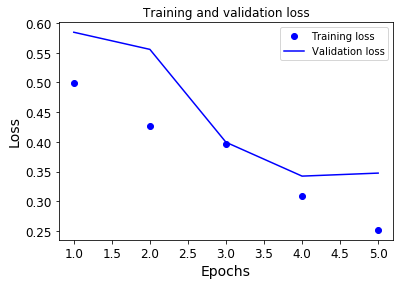

In [52]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


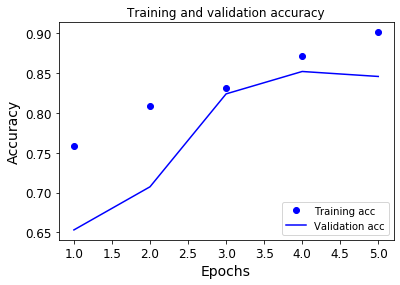

In [53]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()
